In [27]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [13]:
# Load the RGB image
rgb_image_path = "/home/yangze2065/Documents/autonomous_greenhouse_challenge_2024/dataset/4th_dwarf_tomato/image/train/rgb/B_5052e115.png"
rgb_image = cv2.imread(rgb_image_path)
rgb_image_rgb = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)

In [35]:
# Set up the configuration and model for Mask R-CNN
cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # Adjust score threshold to be more lenient
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [36]:
# Create a predictor
predictor = DefaultPredictor(cfg)

# Perform panoptic segmentation
outputs = predictor(rgb_image_rgb)

# Visualize the segmentation result
v = Visualizer(
    rgb_image_rgb[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
segmentation_result = out.get_image()[:, :, ::-1]

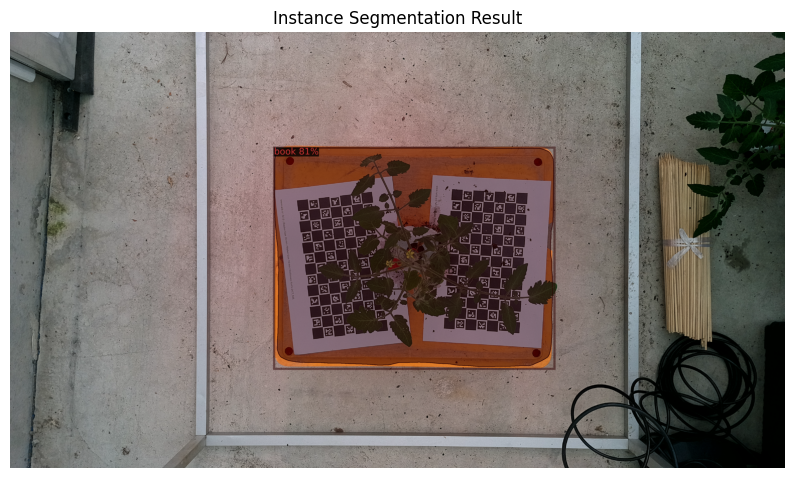

In [37]:
# Show segmentation result
plt.figure(figsize=(10, 10))
plt.title("Instance Segmentation Result")
plt.imshow(segmentation_result)
plt.axis("off")
plt.show()

In [45]:
# Print detected class IDs and their scores
pred_masks = outputs["instances"].pred_masks.to("cpu").numpy()
pred_classes = outputs["instances"].pred_classes.to("cpu").numpy()
scores = outputs["instances"].scores.to("cpu").numpy()
print("Detected class IDs:", pred_classes)
print("Scores:", scores)

# Get the mask of the tomato plants
potted_plant_class_id = 58
tomato_masks = pred_masks[pred_classes == potted_plant_class_id]

# Debug: Print the number of tomato masks found
print(f"Number of tomato masks found: {len(tomato_masks)}")

Detected class IDs: [58 58  0]
Scores: [0.8180528 0.7271325 0.5996621]
Number of tomato masks found: 2


In [46]:
# Combine all instance masks of tomato plants into a single mask
combined_mask = np.zeros(rgb_image.shape[:2], dtype=np.uint8)
for mask in tomato_masks:
    combined_mask = np.logical_or(combined_mask, mask).astype(np.uint8)

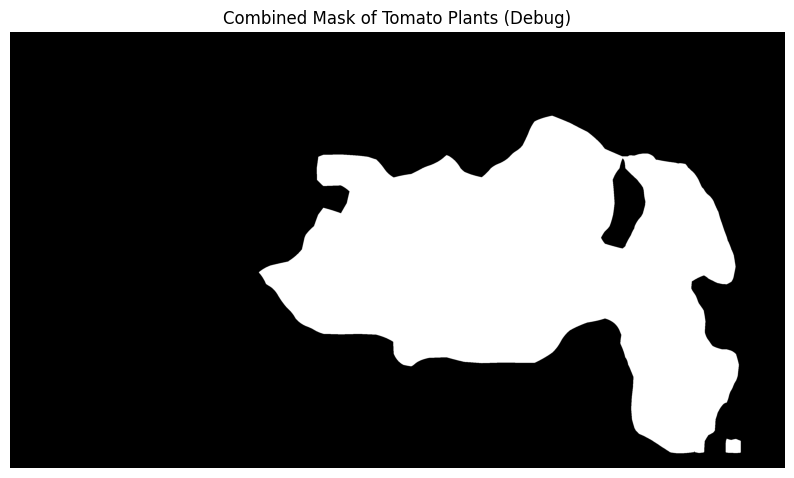

In [48]:
# Debug: Ensure the combined mask is correctly generated
plt.figure(figsize=(10, 10))
plt.title("Combined Mask of Tomato Plants (Debug)")
plt.imshow(combined_mask, cmap="gray")
plt.axis("off")
plt.show()

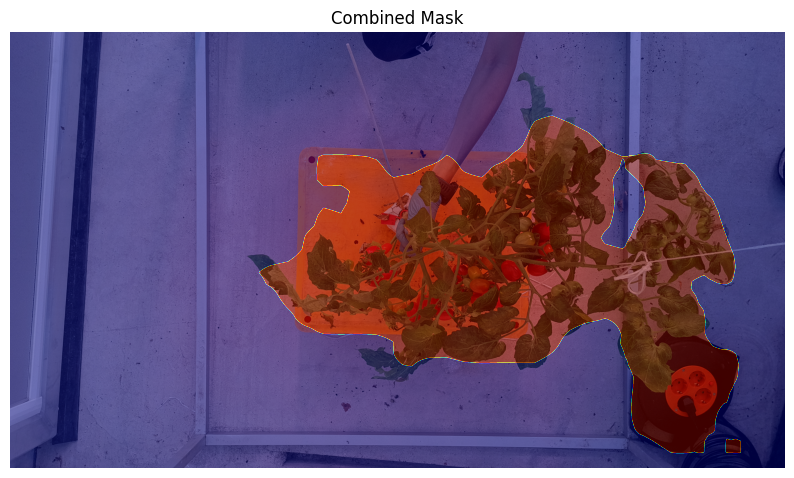

In [47]:
# Visualize the combined mask on the RGB image
plt.figure(figsize=(10, 10))
plt.title("Combined Mask")
plt.imshow(rgb_image_rgb)
plt.imshow(combined_mask, alpha=0.5, cmap="jet")
plt.axis("off")
plt.show()

In [49]:
# Apply the mask to the RGB+D image
# Load the RGB+D image
rgbd_image_path = "../results/B_25f56695_rgbd_output.png"
rgbd_image = cv2.imread(rgbd_image_path, cv2.IMREAD_UNCHANGED)

# Ensure the RGB+D image has 4 channels
print(rgbd_image.shape)

if rgbd_image.shape[2] != 4:
    raise ValueError("The RGB+D image must have 4 channels.")

(2160, 3840, 4)


In [50]:
# Apply the combined mask to the RGB+D image and fill 0 to the unmasked area
masked_rgbd_image = rgbd_image.copy()
masked_rgbd_image[combined_mask == 0] = 0

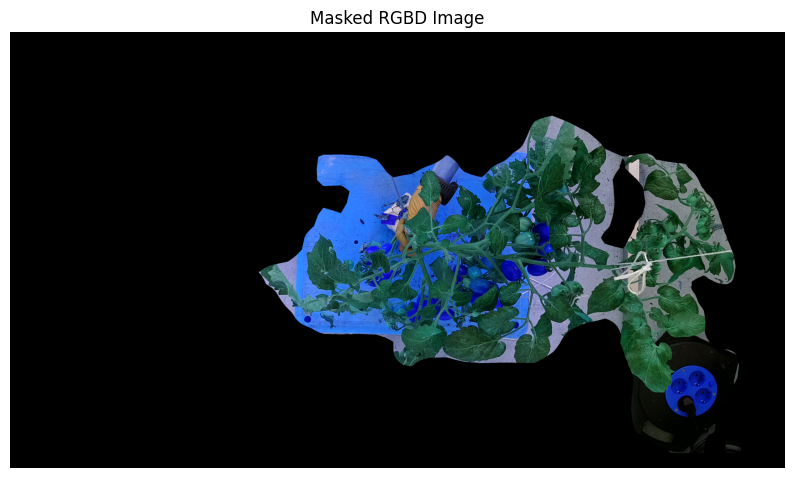

In [62]:
# Visualize the masked RGBD image
plt.figure(figsize=(10, 10))
plt.title("Masked RGBD Image")
plt.imshow(masked_rgbd_image[:, :, :3])  # Show only the RGB channels
plt.axis("off")
plt.show()

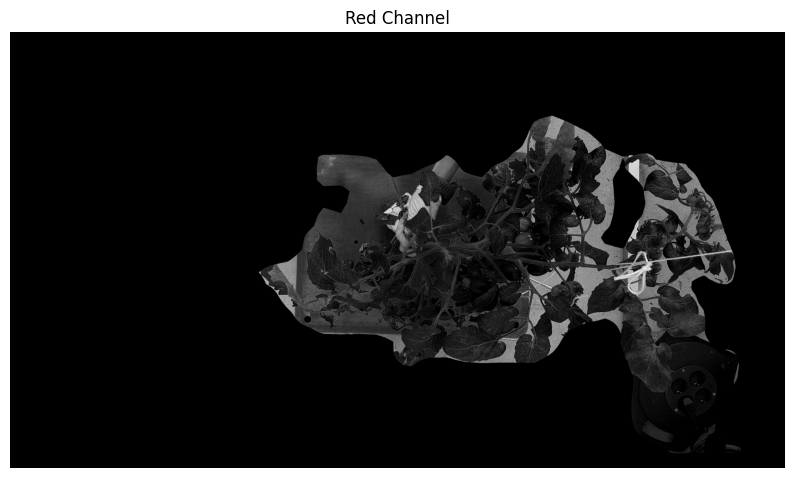

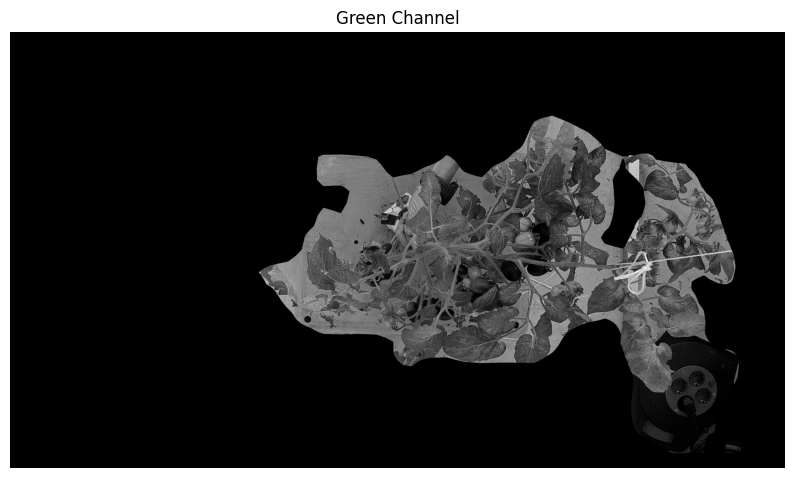

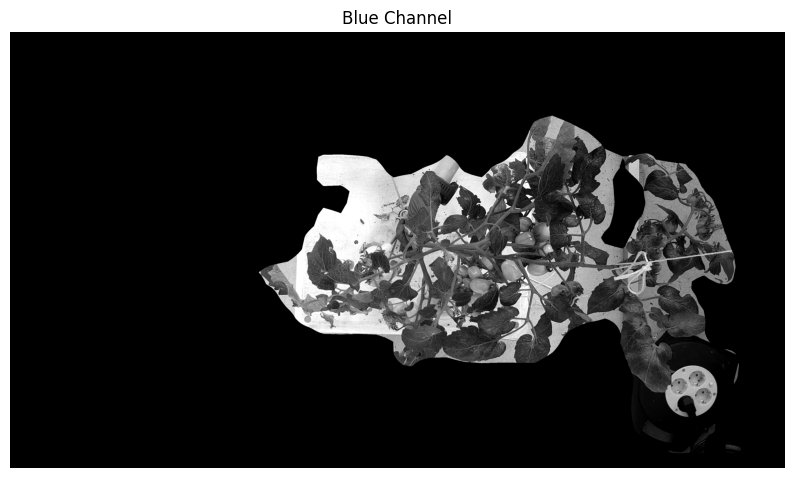

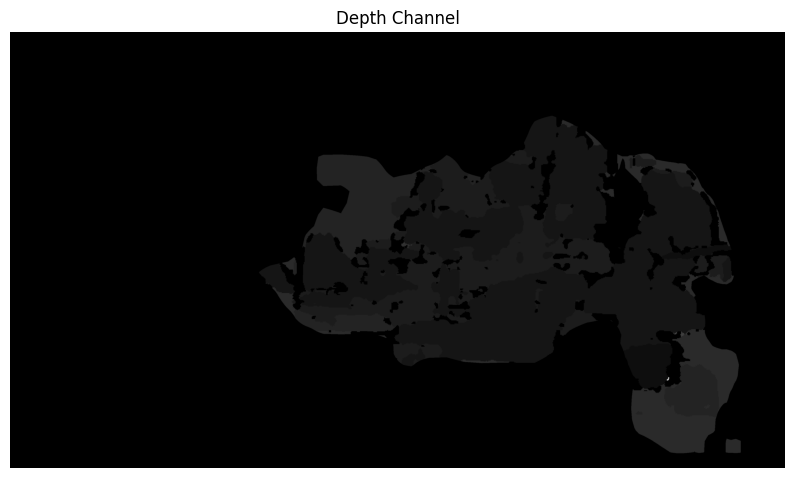

In [67]:
# Visualize each channel of the masked RGBD image
channels = ["Red Channel", "Green Channel", "Blue Channel", "Depth Channel"]
for i, channel in enumerate(channels):
    plt.figure(figsize=(10, 10))
    plt.title(channel)
    plt.imshow(masked_rgbd_image[:, :, i], cmap="gray")
    plt.axis("off")
    plt.show()

In [63]:
# Save the masked RGB+D image
masked_rgbd_image_path = "../results/B_25f56695_masked_output.png"
cv2.imwrite(masked_rgbd_image_path, masked_rgbd_image)

True